In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from numba import jit
from modules.process import Process
from modules.edge import get_bright_edge
from modules.mass_center import compute_mass_center
from modules.bright2dark import get_b2d_data
from modules.dense_area import get_dense_area
from modules.grouping import divideIntoGroups
from modules.helper import get_extention_tag, display_images
from modules.fft import lowpass_filter
from modules.fitting import fit2circle
from modules.mask import to_mask, get_dilated_mask
from modules.contour import get_largest_brightness_diff_contour_id, select_concentric_contour_indices
from modules.sensor_dust import create_sensor_dust_mask
from config import base_dir

In [38]:
def run(instance):
    dilated_dust_mask = get_dilated_mask(instance.dust_mask)
    ellipses = []
    circles = []
    for i in range(60):
        gray = instance.gray_images[i].copy()
        # mass center
        cx, cy = compute_mass_center(gray, dilated_dust_mask)

        # edge points
        edge = get_bright_edge(gray)
        edge[dilated_dust_mask == 1] = 0

        # b2d data
        blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
        b2d_vector_image, cos_image = get_b2d_data(blurred, cx, cy, sobel_ksize=3)

        # b2d mask
        b2d_mask = np.ones(gray.shape)
        b2d_mask[cos_image < 0.3] = 0
        b2d_mask[b2d_vector_image < np.mean(b2d_vector_image)] = 0
        group_sizes, grouped = divideIntoGroups(b2d_mask, ksize=3)
        small_group_mask = np.zeros(b2d_mask.shape)
        for group_id, group_size in enumerate(group_sizes):
            if group_size < 50:
                small_group_mask[grouped == group_id] = 1
        new_b2d_mask = np.copy(b2d_mask)
        new_b2d_mask[small_group_mask == 1] = 0

        # 境界点群の絞り込み
        new_edge = np.copy(edge)
        new_edge[new_b2d_mask == 0] = 0
        new_edge_binary = np.copy(new_edge)
        new_edge_binary[new_edge_binary > 0] = 1
        new_edge_binary = cv2.dilate(new_edge_binary, kernel=(5, 5))

        # 輪郭群の検出と絞り込み
        contours, _ = cv2.findContours(new_edge_binary.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
        standard_contour_id = get_largest_brightness_diff_contour_id(contours, new_edge_binary, b2d_vector_image, instance.dust_mask)
        concentric_contour_indices = select_concentric_contour_indices(contours, standard_contour_id, circle_thickness=10)
        concentric_contours = [c for i, c in enumerate(contours) if i in concentric_contour_indices]
        ellipse = cv2.fitEllipseAMS(np.concatenate(concentric_contours))
        circle = fit2circle(concentric_contours)
        ellipses.append(ellipse)
        circles.append(circle)
    
    return ellipses, circles

def test_run(instance, index):
    gray = instance.gray_images[index]

    # mass center
    dilated_dust_mask = get_dilated_mask(instance.dust_mask)
    cx, cy = compute_mass_center(gray, dilated_dust_mask)

    # edge points
    edge = get_bright_edge(gray)
    edge[dilated_dust_mask == 1] = 0

    # b2d data
    blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
    b2d_vector_image, cos_image = get_b2d_data(blurred, cx, cy, sobel_ksize=3)

    # b2d mask
    b2d_mask = np.ones(gray.shape)
    b2d_mask[cos_image < 0.3] = 0
    b2d_mask[b2d_vector_image < np.mean(b2d_vector_image)] = 0
    group_sizes, grouped = divideIntoGroups(b2d_mask, ksize=3)
    small_group_mask = np.zeros(b2d_mask.shape)
    for group_id, group_size in enumerate(group_sizes):
        if group_size < 50:
            small_group_mask[grouped == group_id] = 1
    new_b2d_mask = np.copy(b2d_mask)
    new_b2d_mask[small_group_mask == 1] = 0

    # 境界点群の絞り込み
    new_edge = np.copy(edge)
    new_edge[new_b2d_mask == 0] = 0
    new_edge_binary = np.copy(new_edge)
    new_edge_binary[new_edge_binary > 0] = 1
    new_edge_binary = cv2.dilate(new_edge_binary, kernel=(5, 5))

    # 輪郭群の検出と絞り込み
    contours, _ = cv2.findContours(new_edge_binary.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
    standard_contour_id = get_largest_brightness_diff_contour_id(contours, new_edge_binary, b2d_vector_image, instance.dust_mask)
    concentric_contour_indices = select_concentric_contour_indices(contours, standard_contour_id, circle_thickness=10)
    concentric_contours = [c for i, c in enumerate(contours) if i in concentric_contour_indices]
    ellipse = cv2.fitEllipseAMS(np.concatenate(concentric_contours))
    circle = fit2circle(concentric_contours)
    print(f'Fitting result:\n ellipse{ellipse}\n circle {circle}')

    canvas_standard_contour = gray.copy()
    cv2.drawContours(canvas_standard_contour, [contours[standard_contour_id]], 0, 0, 3)
    canvas_concentric_contours = gray.copy()
    for i, contour in enumerate(concentric_contours):
        cv2.drawContours(canvas_concentric_contours, [contour], 0, 0, 1)
    canvas_all_contours = gray.copy()
    for i, contour in enumerate(contours):
        cv2.drawContours(canvas_all_contours, [contour], 0, 0, 1)
    
    print(f'Number of concentric contours: {len(concentric_contours)}')
    canvas_ellipse = gray.copy()
    cv2.ellipse(canvas_ellipse, ellipse, color=0, thickness=1)
    canvas_circle = gray.copy()
    circle_x, circle_y, circle_rad = map(int, circle)
    cv2.circle(canvas_circle, (circle_x, circle_y), circle_rad, color=0, thickness=1)
    
    # 描画
    images = [gray, edge, b2d_vector_image, cos_image, b2d_mask, new_b2d_mask, new_edge, new_edge_binary, canvas_standard_contour, canvas_concentric_contours, canvas_all_contours, canvas_ellipse, canvas_circle]
    names = ['gray', 'edge', 'b2d_vector', 'b2d_cos', 'b2d_mask', 'new_b2d_mask', 'new_edge', 'new_edge_binary', 'canvas_standard_contour', 'canvas_concentric_contours', 'canvas_all_contours', 'canvas_ellipse', 'canvas_circle']
    w = int(min(len(images) / 2, 4))
    display_images(images, names, w)
    
    return gray, edge, b2d_vector_image, cos_image, b2d_mask, new_b2d_mask, new_edge, new_edge_binary

In [3]:
path = '/mnt/c/Users/hiran/Documents/Research/Experiment_data/Droplet/20240209/20240209_3-branch_Y3-3x5_deg55_wu_exp100ms_ph2_take1_cropped.tif'
instance = Process(path)

In [35]:
dust_mask = np.zeros(instance.gray_images[0].shape)
cv2.circle(dust_mask, (100, 148), 16, color=1, thickness=-1)
cv2.circle(dust_mask, (523, 305), 13, color=1, thickness=-1)
cv2.circle(dust_mask, (450, 483), 11, color=1, thickness=-1)
instance.dust_mask = dust_mask

Fitting result:
 ellipse((400.3105163574219, 463.23321533203125), (169.5586395263672, 329.66510009765625), 59.30610275268555)
 circle (383.6443612188066, 432.82476340579433, 134.10269627205193)
Number of concentric contours: 36


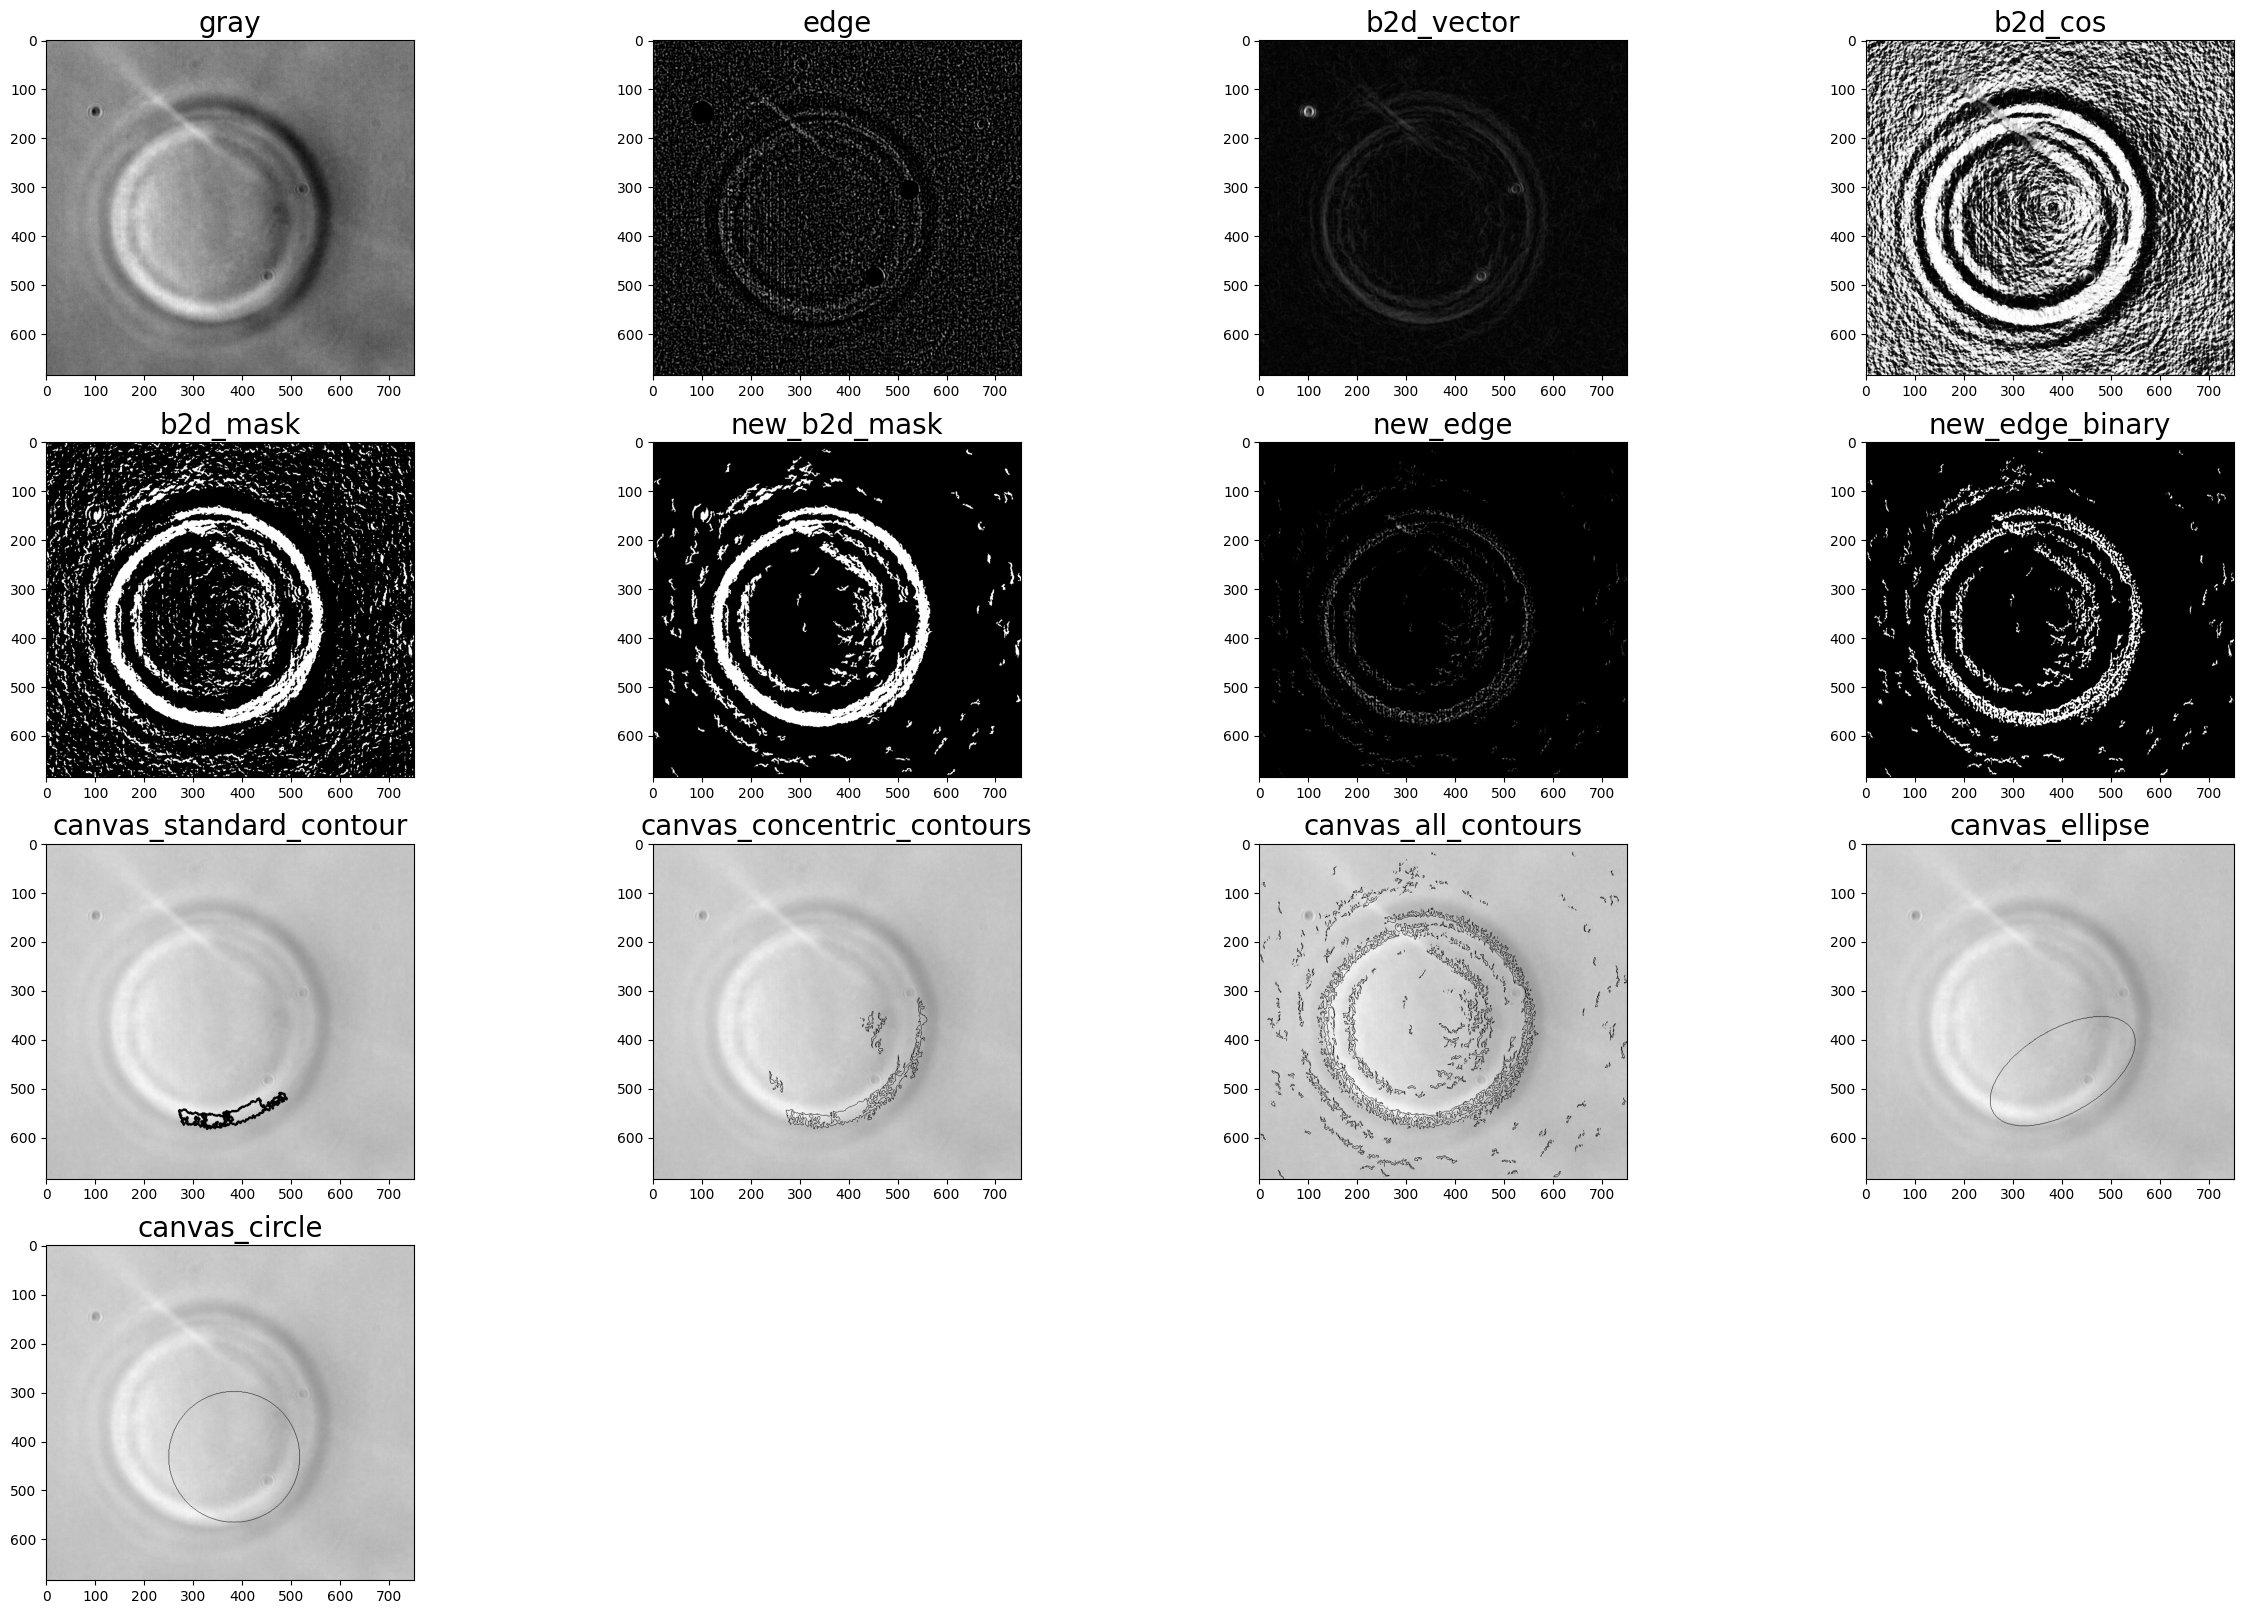

(array([[10775, 10933, 10816, ..., 10628, 10554, 10516],
        [10962, 11106, 10729, ..., 10536, 10572, 10484],
        [10906, 10828, 10808, ..., 10643, 10413, 10712],
        ...,
        [10087,  9993, 10022, ..., 10192, 10224, 10100],
        [10070, 10213, 10156, ..., 10164, 10169, 10322],
        [10155,  9966, 10090, ..., 10365, 10373, 10331]], dtype=uint16),
 array([[1456.,  524.,    0., ...,    0.,    0.,    0.],
        [1456.,  524.,    0., ...,    0.,    0.,    0.],
        [1392.,  492.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,  188., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]], dtype=float32),
 array([[  0.        , 172.        , 128.        , ...,  58.        ,
          54.        ,   0.        ],
        [ 20.        , 162.30834961, 112.29425812, ..., 145.08618164,
         104.80458069,  46.        ],
        [ 42.        , 136.1322937 ,  72.

In [47]:
test_run(instance, 22)

In [39]:
ellipses, circles = run(instance)

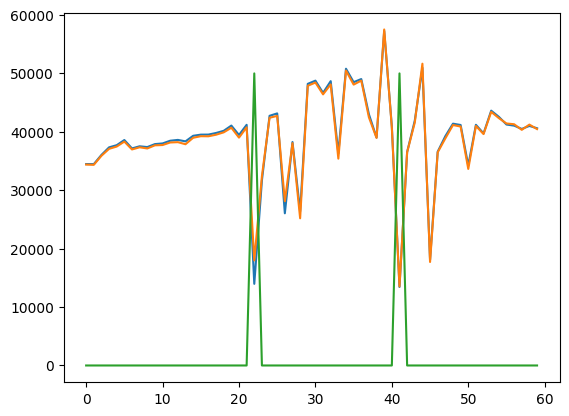

In [44]:
plt.plot([e[1][0] * e[1][1] / 4 for e in ellipses])
plt.plot([c[-1]**2 for c in circles])
signs = np.zeros(len(ellipses))
signs[22] = signs[41] = 5e4
plt.plot(signs)

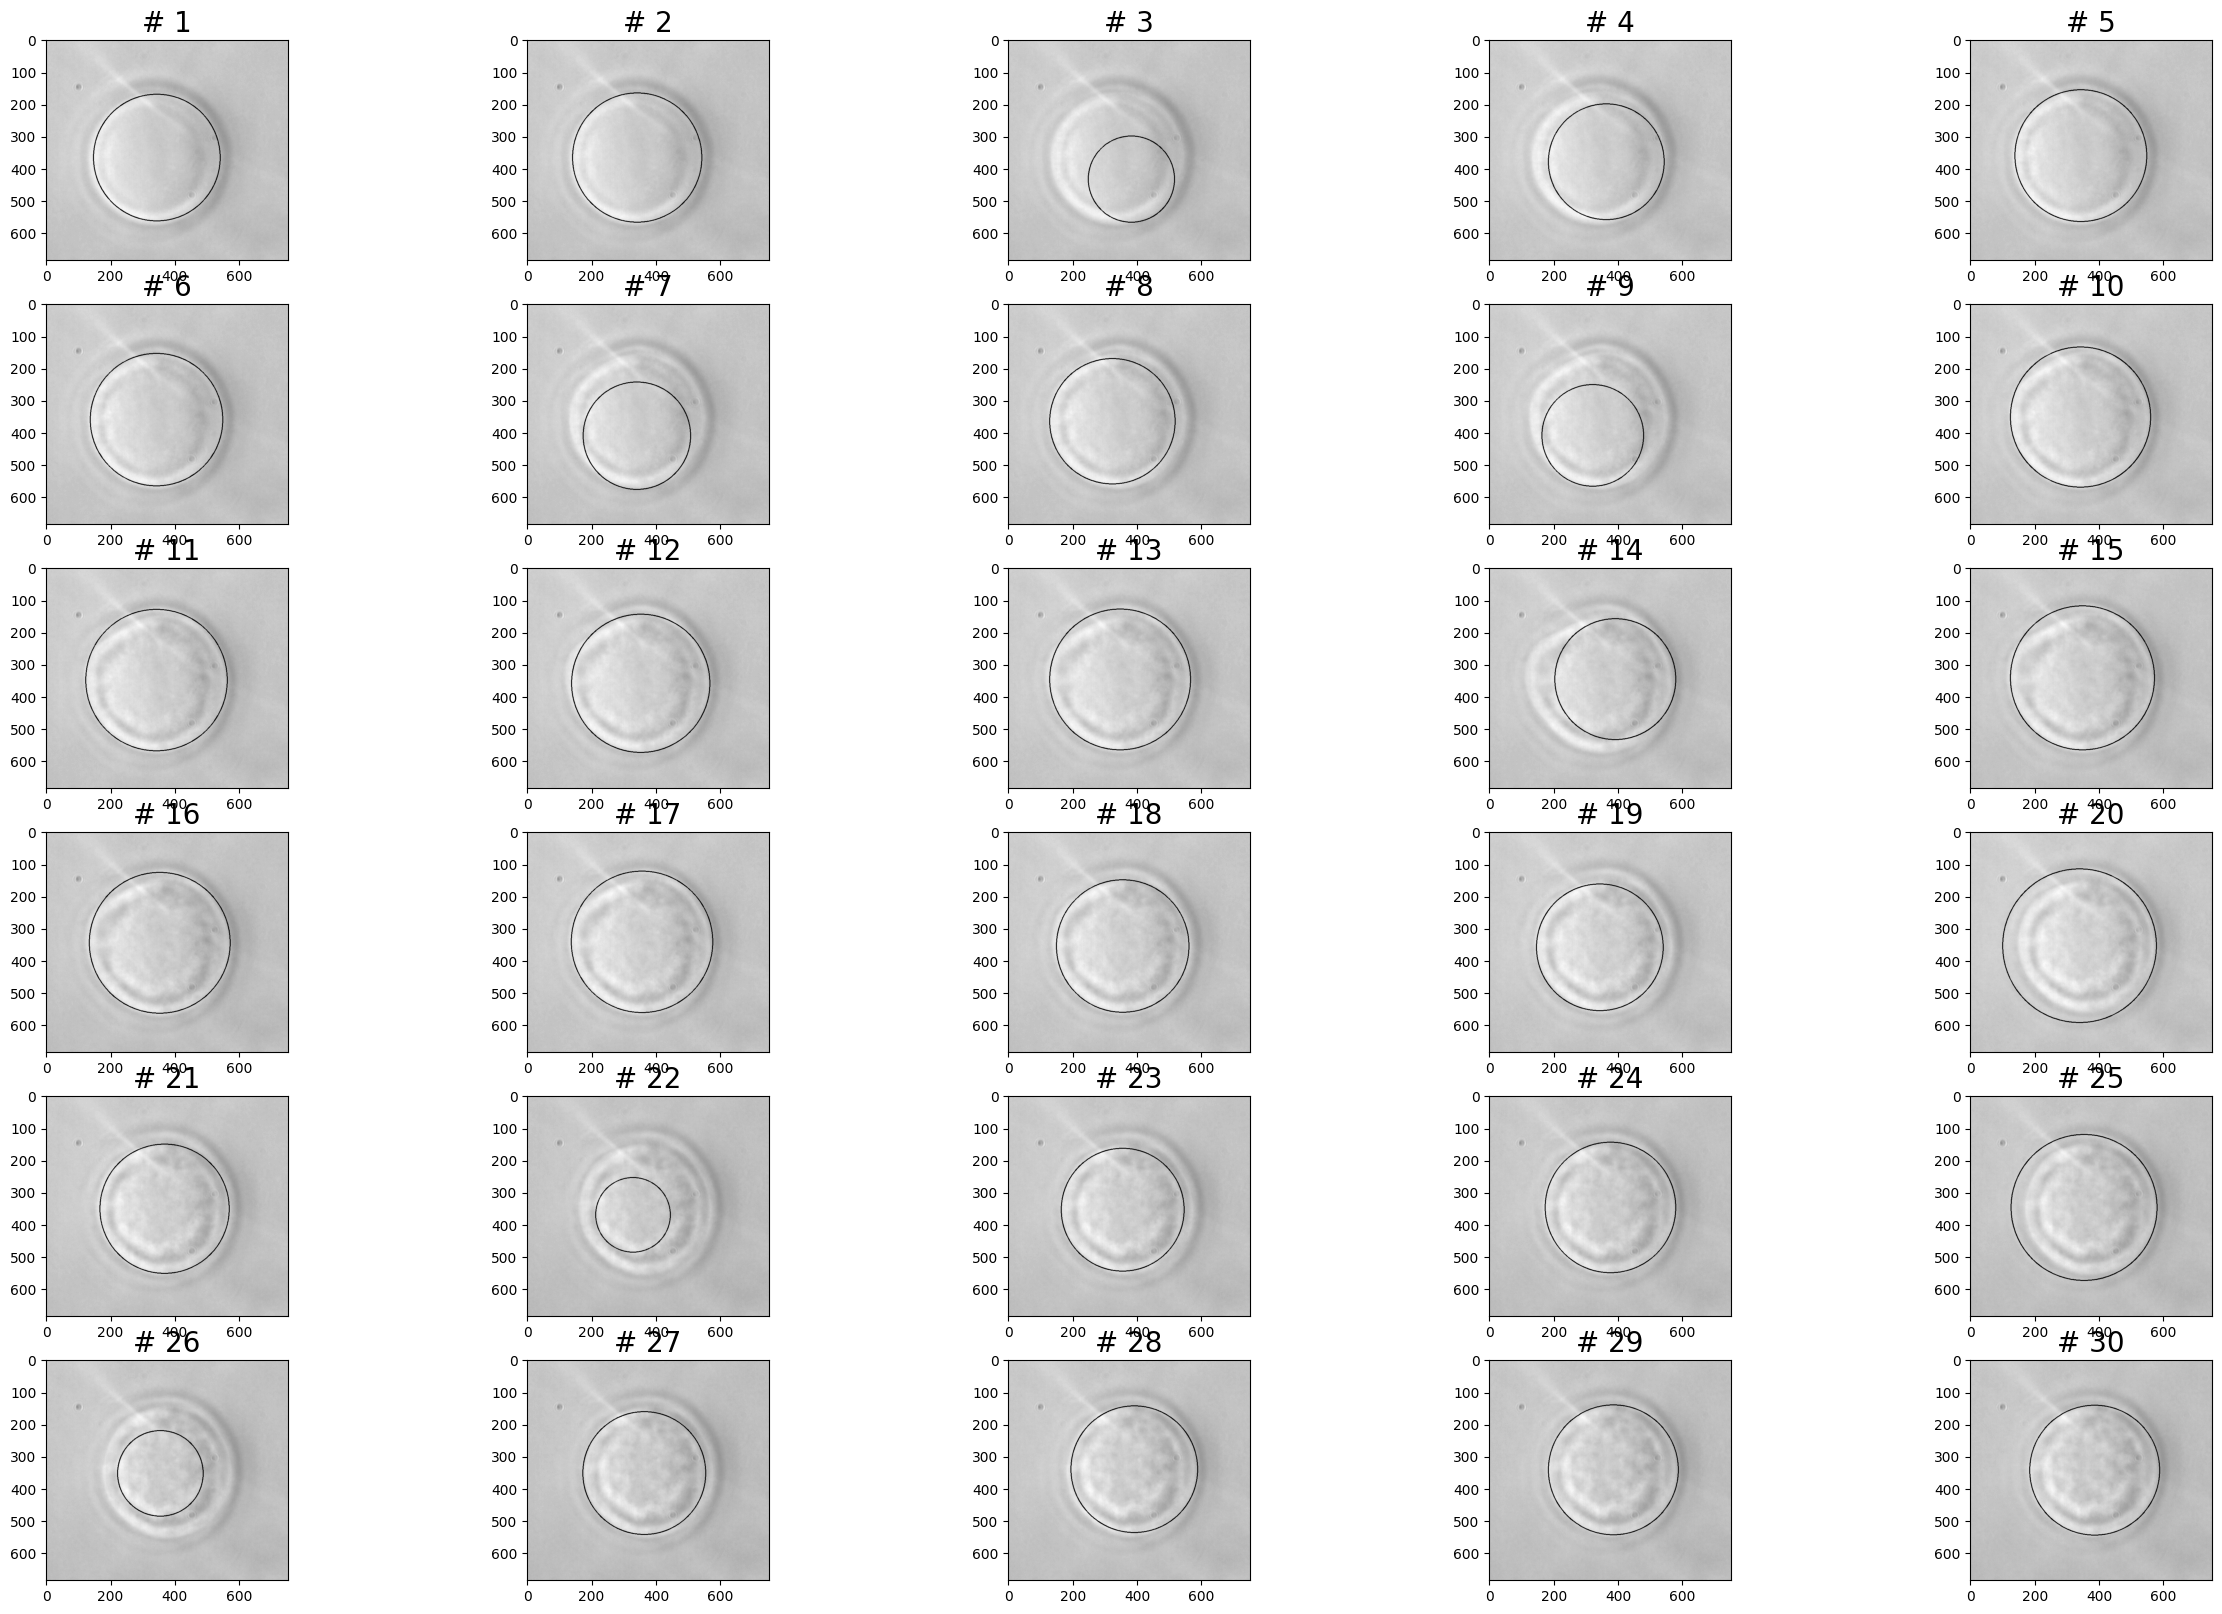

In [ ]:
canvases = np.copy(instance.gray_images)
for i in range(len(ellipses)):
    # cv2.ellipse(canvases[i], ellipses[i], color=0, thickness=3)
    cv2.circle(canvases[i], (int(circles[i][0]), int(circles[i][1])), int(circles[i][2]), 0, 2)
display_images(canvases[20:50], w=5)

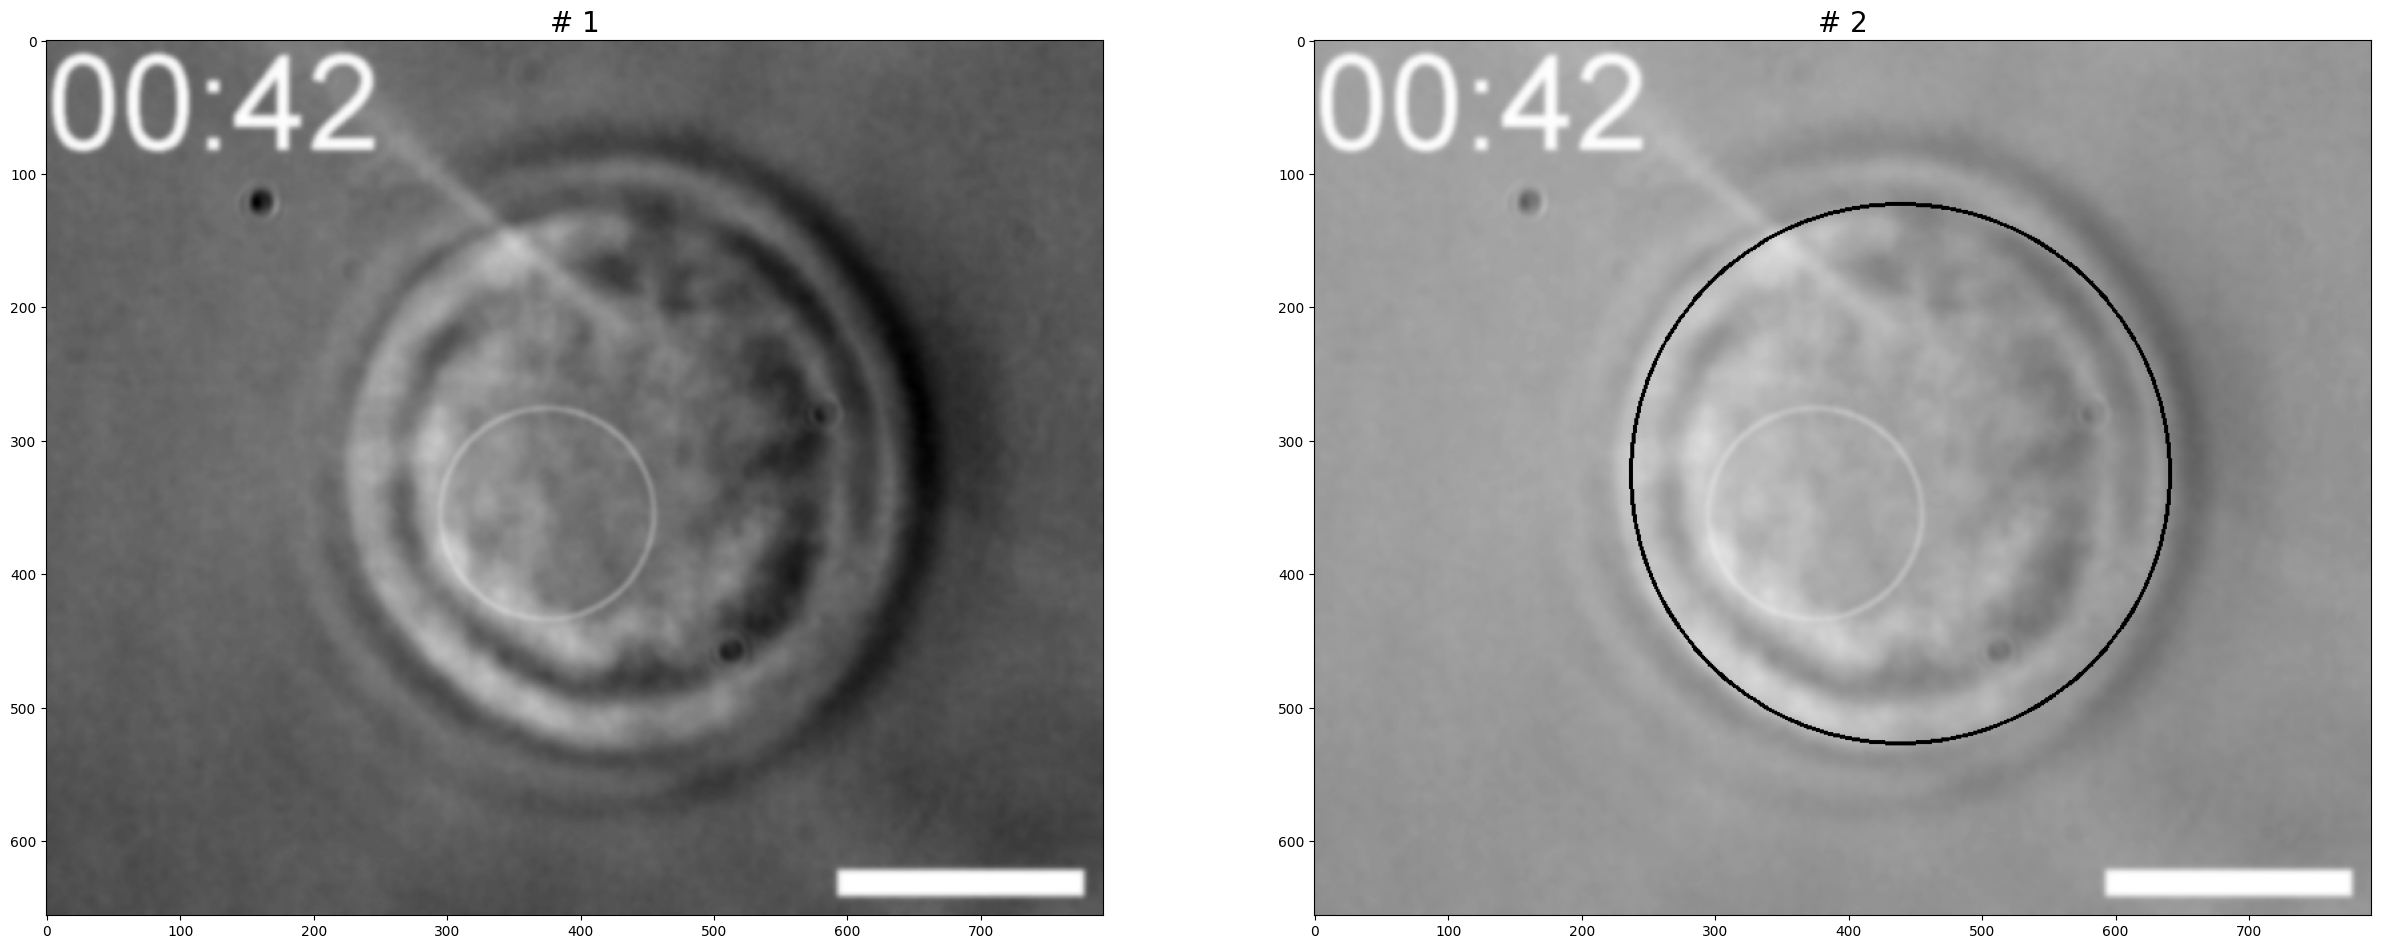

In [ ]:
index = 42
display_images([p.gray_images[index], canvases[index]])

In [ ]:
34, 39, 30, 24, 

1	142556	10968.447	833.269	8203	13577
2	142556	11003.888	853.267	8447	13478
3	141881	10994.862	852.571	7899	13531
4	135948	11060.289	876.401	8307	13479
